In [78]:
# Use this cell to regroup all your imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import set_config; set_config(display='diagram')
from python_files.data import GetData
from python_files.basic_preprocessing import BasicPreprocessing
from python_files.preprocessing import Advancedprocessing
import xgboost as xgb
import collections

# Load

In [79]:
data = pd.read_csv('../data/AllDataMerged_updated.csv')

In [80]:
data.nunique()

id                             8939
budget                          917
genres                         1689
imdb_id                        8712
original_language                56
production_companies           2677
production_countries             89
release_date                   5685
revenue                        6333
runtime                         229
spoken_languages                 60
status                            1
title                          8735
production_companies_number      23
production_countries_number      11
spoken_languages_number          10
belongs_to_collection           812
actor1_name                    4117
actor1_gender                     3
actor2_name                    5333
actor2_gender                     3
actor3_name                    5952
actor3_gender                     3
actor4_name                    6248
actor4_gender                     3
actor5_name                    6329
actor5_gender                     3
actor_number                

In [81]:
data.isnull().sum().sort_values(ascending=False)/len(data)

belongs_to_collection          0.835328
genres                         0.027520
imdb_id                        0.025394
spoken_languages               0.009285
runtime                        0.002909
release_date                   0.002349
original_language              0.000112
director_name                  0.000000
actor4_name                    0.000000
actor4_gender                  0.000000
actor5_name                    0.000000
actor5_gender                  0.000000
actor_number                   0.000000
id                             0.000000
director_gender                0.000000
director_number                0.000000
actor3_name                    0.000000
producer_name                  0.000000
producer_number                0.000000
screeplay_name                 0.000000
actor3_gender                  0.000000
actor1_name                    0.000000
actor2_gender                  0.000000
actor2_name                    0.000000
actor1_gender                  0.000000


In [82]:
data.drop_duplicates(inplace = True)

In [83]:
X = data.drop(columns=['revenue'])
y = data['revenue']

In [84]:
X.head().transpose()

,0,1,2,3,4
id,5,9,11,12,13
budget,4000000,4000000,11000000,94000000,55000000
genres,Crime|Comedy,Drama,Adventure|Action|Science Fiction,Animation|Family,Comedy|Drama|Romance
imdb_id,tt0113101,tt0425473,tt0076759,tt0266543,tt0109830
original_language,en,de,en,en,en
production_companies,Miramax Films,none,Lucasfilm,Pixar Animation Studios,Paramount Pictures
production_countries,United States of America,Germany,United States of America,United States of America,United States of America
release_date,25-12-1995,02-09-2004,25-05-1977,30-05-2003,06-07-1994
runtime,98.0,15.0,121.0,100.0,142.0
spoken_languages,English,Deutsch,English,English,English


We know 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state=6)
X_test, X_val , y_val, y_test = train_test_split(X_test, y_test, test_size = 0.50,random_state=6)

In [86]:
len(X_val)

1341

### 1.2 Baseline pipe

#### a) Preprocessing

In [87]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [88]:
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), RobustScaler())

preproc_basic = make_column_transformer(
    (num_transformer, ['budget','runtime',
        'production_companies_number',
       'production_countries_number', 'spoken_languages_number']))

preproc_basic

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['budget', 'runtime',
                                  'production_companies_number',
                                  'production_countries_number',
                                  'spoken_languages_number'])])

#### b) Add estimator

In [89]:
from sklearn.linear_model import LinearRegression

In [90]:
pipe_baseline = make_pipeline(preproc_basic, LinearRegression())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['budget', 'runtime',
                                                   'production_companies_number',
                                                   'production_countries_number',
                                                   'spoken_languages_number'])])),
                ('linearregression', LinearRegression())])

#### c) Cross-Validate

In [91]:
from sklearn.model_selection import cross_val_score

# Cross-validate Pipeline
score_baseline = cross_val_score(pipe_baseline, X_train, y_train, cv=5, scoring='r2').mean()
score_baseline

0.5084871710554204

## 🏋️‍♀️ 2. ITERATIONS 

**Estimators**

- **Tree-based ensembles (must try today)**: Probably the best suited for problems with many categorical features
- Stacking !
- XGBoost !

**Preprocessing** (once your first ensemble model works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict `log(SalePrice)` instead?
- ...

### 2.1 Genre Addition ♲ 

In [92]:
from sklearn.base import TransformerMixin, BaseEstimator

class GenreTranformer(TransformerMixin, BaseEstimator): 
    # BaseEstimator generates the get_params() and set_params() methods that all Pipelines require
    # TransformerMixin creates the fit_transform() method from fit() and transform()
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.unique_genre_list = []
        for genres in X:
            for genre in genres[0].split('|'):
                if genre not in self.unique_genre_list:
                    self.unique_genre_list.append(genre)
        return self   
    
    def transform(self, X, y=None):
        unique_genre_list = self.unique_genre_list
        genre_transformed = [] 
        for genres in X:
            genre_np = np.zeros((len(unique_genre_list),), dtype=int)
            for target_genre in genres[0].split('|'):
                if target_genre in unique_genre_list:
                        index = unique_genre_list.index(target_genre)
                        genre_np[index] = 1
            genre_transformed.append(list(genre_np))
        return np.array(genre_transformed)

## Cast transformer

In [93]:
class CastTransformer(TransformerMixin, BaseEstimator): 
    # BaseEstimator generates the get_params() and set_params() methods that all Pipelines require
    # TransformerMixin creates the fit_transform() method from fit() and transform()
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
#         for feature_number in range(X.shape[1]):
#         def top_k(feature, k):
#         feature_top_k = np.partition(X[:,0], -k)[-k:]
#         self.popular_actor_list = np.sort(feature_top_k)[::-1]
        return self   
    
    def transform(self, X, y=None):
        popular_actor_list = ['Nicolas Cage',
  'Johnny Depp',
  'Ajith Kumar',
  'Bruce Willis',
  'Tom Cruise',
  'Denzel Washington',
  'Tom Hanks',
  'Adam Sandler',
  'Robert De Niro',
  'John Travolta',
  'Eddie Murphy',
  'John Wayne',
  'Keanu Reeves',
  'Arnold Schwarzenegger',
  'Ben Affleck',
  'Jeff Bridges',
  'George Clooney',
  'Harrison Ford',
  'Matt Damon',
  'Liam Neeson',
  'Kevin Costner',
  'Mark Wahlberg',
  'Clint Eastwood',
  'Jason Statham',
  'Mel Gibson',
  'Jackie Chan',
  'Sylvester Stallone',
  'Meryl Streep',
  'Ben Stiller',
  'Christian Bale']
        popular_director_list = ['Steven Spielberg',
  'Woody Allen',
  'Ridley Scott',
  'Alfred Hitchcock',
  'Clint Eastwood',
  'Steven Soderbergh',
  'Oliver Stone',
  'Martin Scorsese',
  'Robert Rodriguez',
  'John Carpenter',
  'Tim Burton',
  'John Ford',
  'Wes Craven',
  'Francis Ford Coppola',
  'Ron Howard',
  'Roland Emmerich',
  'Robert Zemeckis',
  'Michael Bay',
  'Billy Wilder',
  'Bobby Farrelly',
  'Renny Harlin',
  'Sam Raimi',
  'Peter Jackson',
  'Walter Hill',
  'Tony Scott',
  'Richard Donner',
  'Brian De Palma',
  'Barry Levinson',
  'Spike Lee',
  'John Landis']
        popular_producer_list = ['Joel Silver',
  'Jerry Bruckheimer',
  'Brian Grazer',
  'Neal H. Moritz',
  'Tim Bevan',
  'Luc Besson',
  'John Davis',
  'Michael Bay',
  'Scott Rudin',
  'Arnon Milchan',
  'Danny DeVito',
  'Clint Eastwood',
  'Roger Birnbaum',
  'Ridley Scott',
  'Charles Roven',
  'Steve Golin',
  'Ronnie Screwvala',
  'Albert R. Broccoli',
  'Lawrence Gordon',
  'Walt Disney',
  'Tom Rosenberg',
  'Gale Anne Hurd',
  'Alfred Hitchcock',
  'Lawrence Bender',
  'Kathleen Kennedy',
  'Nick Wechsler',
  'Steven Spielberg',
  'John Hughes',
  'Judd Apatow',
  'Robert Rodriguez']
        popular_prod_company_list = ['Universal Pictures',
  'Paramount Pictures',
  'Twentieth Century Fox Film Corporation',
  'Columbia Pictures',
  'New Line Cinema',
  'Walt Disney Pictures',
  'Warner Bros.',
  'Metro-Goldwyn-Mayer (MGM)',
  'United Artists',
  'Columbia Pictures Corporation',
  'Miramax Films',
  'TriStar Pictures',
  'Village Roadshow Pictures',
  'DreamWorks SKG',
  'Fox Searchlight Pictures',
  'Summit Entertainment',
  'Touchstone Pictures',
  'Orion Pictures',
  'Lions Gate Films',
  'BBC Films',
  'Lionsgate',
  'Imagine Entertainment',
  'The Weinstein Company',
  'Regency Enterprises',
  'RKO Radio Pictures',
  'Hollywood Pictures',
  'Lakeshore Entertainment',
  'StudioCanal',
  'Lucasfilm',
  'Dimension Films']
        actor_transformed = [] 
        director_transformed = []
        producer_transformed = []
        production_company_transformed = []
        actor_np = np.zeros((30,), dtype=int)
        director_np = np.zeros((30,), dtype=int)
        producer_np = np.zeros((30,), dtype=int)
        production_company_np = np.zeros((30,), dtype=int)
#         for actor in X[:,0]:
#             if actor in popular_actor_list:
#                         index = popular_actor_list.index(actor)
#                         actor_np[index] = 1
#             actor_transformed.append(list(actor_np))
        for director in X[:,0]:
            if director in popular_director_list:
                        index = popular_director_list.index(director)
                        director_np[index] = 1
            director_transformed.append(list(director_np))
        for producer in X[:,1]:
            if producer in popular_producer_list:
                        index = popular_producer_list.index(producer)
                        producer_np[index] = 1
            producer_transformed.append(list(producer_np))
        for pc in X[:,2]:
            if pc in popular_prod_company_list:
                        index = popular_prod_company_list.index(pc)
                        production_company_np[index] = 1
            production_company_transformed.append(list(production_company_np))
        return np.concatenate((director_transformed,producer_transformed,production_company_transformed),axis = 1)

In [94]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
import datetime

class DataframeTransformer:
    @staticmethod
    def names():
        return list(range(19))
        

    @staticmethod
    def transformer(X):
        
        X['release_date'] = pd.to_datetime(X['release_date'],infer_datetime_format=True)
        
        X['belongs_to_collection_updated'] = X['belongs_to_collection'].apply(lambda x: 0 if pd.isnull(x) else 1)
        # add weekday
        X['release_weekday'] = X['release_date'].dt.day_name()
        #Log of budget
        X['log_budget'] = np.log(X['budget'])
        #find age of movie
        now = pd.to_datetime('now')
        X['release_age'] = (now - X['release_date']).astype('<m8[Y]')

        X['week_sin'] = np.sin(2 * np.pi * X['release_date'].dt.isocalendar().week/52)

        X['week_cos'] = np.cos(2 * np.pi * X['release_date'].dt.isocalendar().week/52)
        return X

In [95]:
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
cast_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), CastTransformer())
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore',sparse=False))
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), RobustScaler())
cyclic_transformer = make_pipeline(SimpleImputer(strategy='mean'))
genre_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), GenreTranformer())

basic_prepoc_steps = FunctionTransformer(lambda df: DataframeTransformer.transformer(df))

processing_pipeline = ColumnTransformer([
    ('Numerical Features Transformer',num_transformer, ['log_budget','release_age','runtime','production_companies_number','production_countries_number','actor_number','producer_number','director_number']),
    ('Genres Transformer',genre_transformer,['genres']),
    ('Cast Transformer',cast_transformer,['director_name','producer_name','production_companies'] ),
    ('Cyclic Transformer',cyclic_transformer,['week_cos','week_sin']),
    ('Category_Transformer', cat_transformer, [ 'production_countries','belongs_to_collection_updated'])
])
feature_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, # keep only 25% of all features
)


union = Pipeline([
    ('basic_prepoc',basic_prepoc_steps),
    ('processing_pipeline', processing_pipeline),
#     ('select percentile',feature_selector)
#     ('linear_reg',LinearRegression())
])
union

Pipeline(steps=[('basic_prepoc',
                 FunctionTransformer(func=<function <lambda> at 0x7fd1cfa10430>)),
                ('processing_pipeline',
                 ColumnTransformer(transformers=[('Numerical Features '
                                                  'Transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['log_budget', 'release_age',
                                                   'runtime',
                                                   'production_companies_number',
                                                   'production_cou...
                                                   'production_companies']),
                                                 ('Cyclic Transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['week_cos', 'week_sin']),
                                                 ('Category_Transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['production_countries',
                                                   'belongs_to_collection_updated'])]))])

In [96]:
union.fit(X_train)

Pipeline(steps=[('basic_prepoc',
                 FunctionTransformer(func=<function <lambda> at 0x7fd1cfa10430>)),
                ('processing_pipeline',
                 ColumnTransformer(transformers=[('Numerical Features '
                                                  'Transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['log_budget', 'release_age',
                                                   'runtime',
                                                   'production_companies_number',
                                                   'production_cou...
                                                   'production_companies']),
                                                 ('Cyclic Transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['week_cos', 'week_sin']),
                                                 ('Category_Transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['production_countries',
                                                   'belongs_to_collection_updated'])]))])

In [97]:
# corr_num = X_train_transformed[['log_budget','release_age','runtime','production_companies_number','production_countries_number', 'spoken_languages_number','actor_number','producer_number','director_number','week_cos','week_sin']].corr()
# plt.figure(figsize=(7,5))
# sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);


In [98]:
# # Converting the correlation matrix into a DataFrame
# corr_df = corr_num.stack().reset_index()

# # Renaming the columns
# corr_df.columns = ['feature_1','feature_2', 'correlation']

# # Remove "self correlations"
# no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
# corr_df = corr_df[no_self_correlation]
# # Computing the absolute correlation
# corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# # Showing the top 5 most correlated pairs of feature
# corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*2)

In [99]:
X_train_transformed = pd.DataFrame(union.transform(X_train))
X_val_transformed = pd.DataFrame(union.transform(X_val))
X_test_transformed = pd.DataFrame(union.transform(X_test))

In [100]:
y_train_transformed = y_train.apply(lambda x: np.log(1+x))
y_val_transformed = y_val.apply(lambda x: np.log(1+x))
y_test_transformed = y_test.apply(lambda x: np.log(1+x))

In [101]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=20)
# pca_x_train = pca.fit_transform(X_train_transformed)
# pca_x_test = pca.transform(X_test_transformed)
# pca.explained_variance_ratio_

## Models

#### Kent Random Forest

In [140]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100)

cv_results_forest = cross_validate(forest, X_train_transformed, y_train_transformed, scoring = "r2", cv=5)

In [141]:
cv_results_forest['test_score'].mean()

0.48787339692351794

#### Kent XGBoost

In [102]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(max_depth=10, n_estimators=100,learning_rate=0.1)

xgb_reg.fit(X_train_transformed, y_train_transformed,
    # evaluate loss at each iteration
    eval_set=[(X_train_transformed, y_train_transformed), (X_val_transformed, y_val_transformed)],  
    # stop iterating when eval loss increases 5 times in a row
    early_stopping_rounds=5
)

[0]	validation_0-rmse:14.76356	validation_1-rmse:14.78749
[1]	validation_0-rmse:13.30665	validation_1-rmse:13.34673
[2]	validation_0-rmse:11.99717	validation_1-rmse:12.05381
[3]	validation_0-rmse:10.82040	validation_1-rmse:10.89527
[4]	validation_0-rmse:9.76297	validation_1-rmse:9.86232
[5]	validation_0-rmse:8.81352	validation_1-rmse:8.93882
[6]	validation_0-rmse:7.96112	validation_1-rmse:8.11270
[7]	validation_0-rmse:7.19635	validation_1-rmse:7.38009
[8]	validation_0-rmse:6.51058	validation_1-rmse:6.72522
[9]	validation_0-rmse:5.89481	validation_1-rmse:6.15108
[10]	validation_0-rmse:5.34307	validation_1-rmse:5.64065
[11]	validation_0-rmse:4.84790	validation_1-rmse:5.19893
[12]	validation_0-rmse:4.40442	validation_1-rmse:4.80982
[13]	validation_0-rmse:4.00856	validation_1-rmse:4.48216
[14]	validation_0-rmse:3.65311	validation_1-rmse:4.18245
[15]	validation_0-rmse:3.33594	validation_1-rmse:3.92785
[16]	validation_0-rmse:3.05169	validation_1-rmse:3.70850
[17]	validation_0-rmse:2.79937	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [103]:
y_test_predict = xgb_reg.predict(X_test_transformed)

In [104]:
from sklearn.metrics import mean_squared_error as mse

mse(y_test_transformed, y_test_predict)

6.991031968917088

#### PCA

In [105]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD
svd = TruncatedSVD(n_components=203)
latent_df = svd.fit_transform(X_train_transformed)

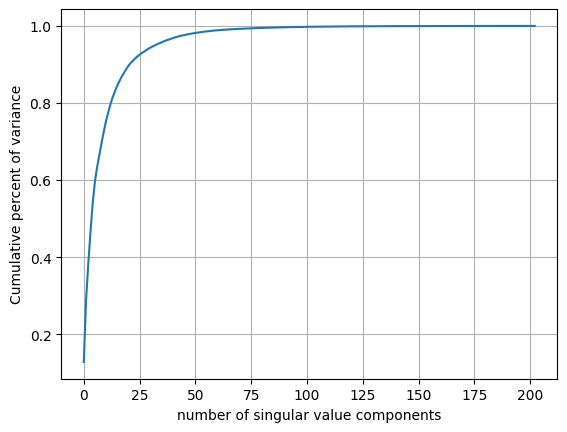

In [106]:
plt.show()
# Plot variance as a function of the number of components.
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [163]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(X_train_transformed)


PCA(n_components=30)

In [164]:
X_proj = pca.transform(X_train_transformed)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 31)])
X_proj
# pca_x_test = pca.transform(X_test_transformed)
# pca.explained_variance_ratio_

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,6.922965,0.010935,-0.845396,-0.353585,0.197837,3.664939,0.116835,-0.368087,-0.524113,1.241237,...,1.148851,-0.333118,-0.088589,-0.232424,0.097063,0.090100,0.476464,-0.121087,-0.334075,0.193534
1,6.906747,-0.667713,-0.101483,0.011755,-0.177858,3.692864,-0.999460,0.289930,0.320136,0.758542,...,1.107967,-0.225866,-0.139039,-0.437340,-0.024359,0.583097,0.135800,-0.422327,-0.178559,0.164585
2,6.890405,-0.383279,1.186355,0.139569,-1.662482,3.589445,1.253152,-1.115747,-0.243369,-0.052928,...,1.216119,-0.234968,0.068287,-0.184602,0.058519,0.127896,0.447352,-0.184662,-0.255087,0.239984
3,6.934194,-0.165142,-0.939978,-0.035875,0.209218,3.687189,0.238069,0.419440,-0.653868,1.366853,...,1.111740,-0.342512,-0.059092,-0.169995,0.262396,0.300438,0.263480,-0.280656,0.748339,0.142697
4,6.938657,-1.500896,1.036201,0.052887,0.860654,3.673179,0.695114,-0.519813,-0.083446,1.060698,...,1.196342,-0.306844,0.023686,-0.284733,0.096920,0.080016,0.474760,-0.101667,-0.349276,0.193086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6252,-0.856562,-0.942988,-0.274564,-0.131826,-0.038626,0.369354,0.021253,0.619354,-0.208480,-0.574353,...,-0.081474,-0.096749,0.103757,0.085708,0.132592,0.017780,-0.021848,0.204772,-0.023452,-0.066018
6253,-0.725276,-3.860623,0.277880,-1.311291,-0.777182,0.320001,2.452503,-0.070880,0.631377,-0.124526,...,-0.013825,-0.196221,0.188242,-0.029251,-0.076411,-0.067833,0.130952,-0.095781,-0.120991,0.087322
6254,-0.842200,-0.541092,-0.602570,0.099146,-0.563992,0.372741,-0.241230,0.942051,-1.060635,0.151542,...,-0.093532,0.193072,0.364805,-0.154110,-0.423997,0.177198,0.015555,-0.320074,-0.165187,-0.096573
6255,-0.842578,-0.151119,-0.534554,-0.326493,-0.805100,0.303468,0.902557,-0.989869,-0.767463,0.219408,...,-0.036614,-0.136115,-0.084167,-0.123502,-0.025405,-0.009586,0.065838,-0.074594,-0.018078,0.041571


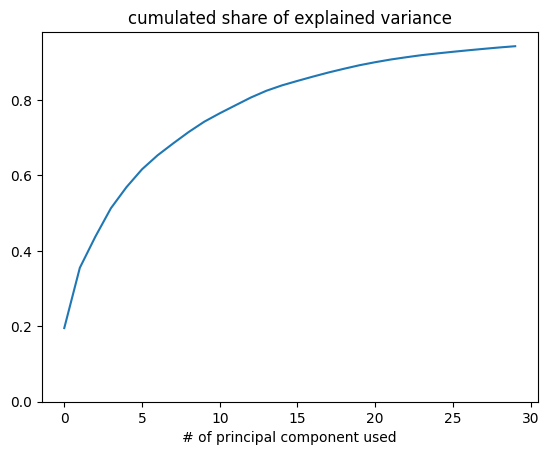

In [165]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [166]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(forest, X_proj, y_train_transformed, cv=5, scoring ='r2').mean())


0.4572719552517775


In [167]:
print(cross_val_score(gbr_model, X_proj, y_train_transformed, cv=5, scoring ='r2').mean())

0.4714625407247732


In [168]:
X_reconstructed = pca.inverse_transform(X_proj)
X_reconstructed.shape

(6257, 203)

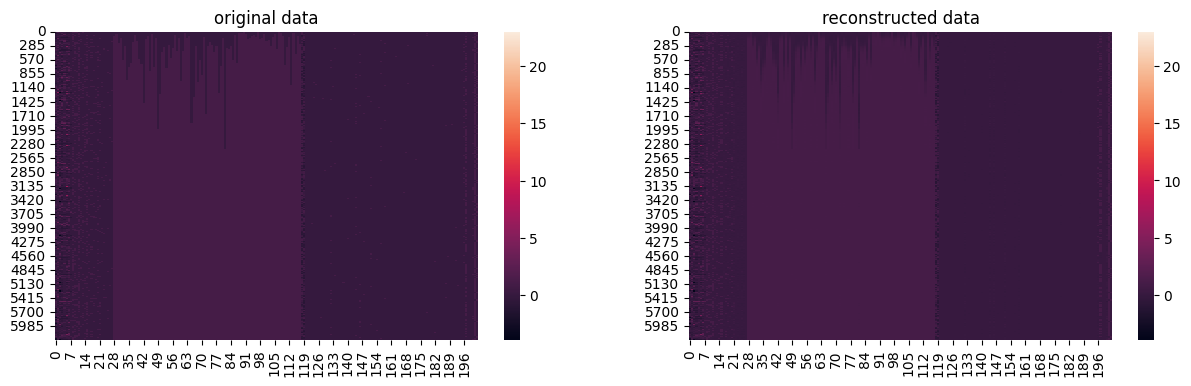

In [169]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.heatmap(X_train_transformed)
plt.title("original data")
plt.subplot(1,2,2)
plt.title("reconstructed data")
sns.heatmap(X_reconstructed);

In [170]:
from sklearn.decomposition import PCA

def pca_dec(data, n):
  pca = PCA(n)
  X_dec = pca.fit_transform(data)
  return X_dec, pca

#Decomposing the train set:
pca_train_results, pca_train = pca_dec(X_train_transformed, 30)

#Decomposing the test set:
pca_test_results, pca_test = pca_dec(X_test_transformed, 30)

#Creating a table with the explained variance ratio
names_pcas = [f"PCA Component {i}" for i in range(1, 31, 1)]
scree = pd.DataFrame(list(zip(names_pcas, pca_train.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])
print(scree)

           Component  Explained Variance Ratio
0    PCA Component 1                  0.195329
1    PCA Component 2                  0.159684
2    PCA Component 3                  0.082769
3    PCA Component 4                  0.075349
4    PCA Component 5                  0.055865
5    PCA Component 6                  0.047350
6    PCA Component 7                  0.037072
7    PCA Component 8                  0.031494
8    PCA Component 9                  0.030278
9   PCA Component 10                  0.027307
10  PCA Component 11                  0.022392
11  PCA Component 12                  0.020985
12  PCA Component 13                  0.020841
13  PCA Component 14                  0.017935
14  PCA Component 15                  0.014243
15  PCA Component 16                  0.011912
16  PCA Component 17                  0.011436
17  PCA Component 18                  0.010908
18  PCA Component 19                  0.009932
19  PCA Component 20                  0.009376
20  PCA Compo

#### Stacking Regressor

In [131]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
     ('lr', RidgeCV()),
     ('svr', LinearSVR(random_state=42))
 ]
reg = StackingRegressor(
     estimators=estimators,
     final_estimator=RandomForestRegressor(n_estimators=10,
                                           random_state=42)
 )

In [132]:
reg.fit(X_train_transformed, y_train_transformed).score(X_test_transformed, y_test_transformed)

-0.6157392710949665

In [135]:
def plot_histogram_cv_results(cv_results):
    # Calculating the std and the mean
    std = cv_results['test_score'].std()
    mean = cv_results['test_score'].mean()
    
    # Getting the number of folds
    n_cv = len(cv_results['test_score'])
    
    # Building plot
    plt.hist(cv_results['test_score'], bins=n_cv)
    
    # Creating red lines
    plt.vlines(mean, 0, 3, color='red', label=f'mean = {mean:.2f}')
    plt.hlines(
        3, mean - 1/2 * std, mean + 1/2 * std, 
        color='red', label=f'std = {std:.2f}', ls='dotted'
    )

    # Setting the title
    plt.title('Histogram of R2 Scores During Cross-Validation')

    # Setting the labels and xlim
    plt.xlim((-1, 1))
    
    plt.xlabel('r2')
    plt.ylabel('number of folds')
    
    # Showing the legend
    plt.legend(loc='upper left')
    
    plt.show()

In [136]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

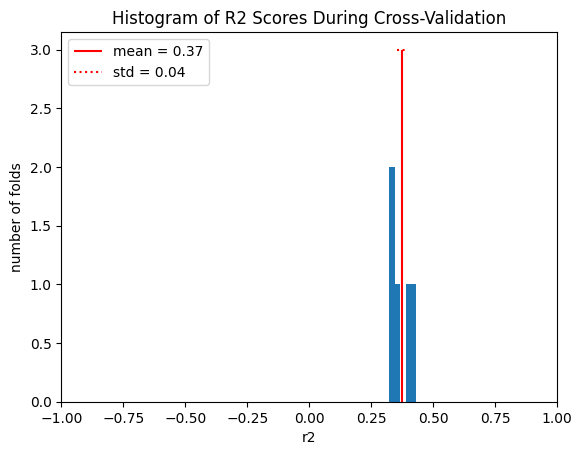

In [138]:
adaboost = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=3),
    n_estimators=50)

cv_results_ada = cross_validate(adaboost, X_train_transformed, y_train_transformed, scoring = "r2", cv=5)

plot_histogram_cv_results(cv_results_ada)

In [139]:
cv_results_ada['test_score'].mean()

0.37383114353998853

#### GradientBoost 

In [142]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=3
)

In [143]:
cv_results_gbr = cross_validate(gbr_model, X_train_transformed, y_train_transformed, scoring = "r2", cv=5)

In [144]:
cv_results_gbr['test_score'].mean()

0.4919656160082151

In [147]:
gbr_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [148]:
from sklearn.model_selection import GridSearchCV

gbr_search = GridSearchCV(
    gbr_model,
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate':[0.1, 0.2, 0.3],
        'max_depth': [1, 2, 3, 4, 5]
    },
    cv=5,
    scoring='r2', verbose =1)

In [149]:
y_predict_gbr = gbr_search.fit(X_train_transformed,y_train_transformed)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [150]:
gbr_search.best_score_

0.5027788425150582

In [151]:
gbr_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

#### XGBoost

In [32]:
# Create DMatrix for train set, cross-validation set and test set (which is X_cross)
train_set = xgb.DMatrix(X_train_transformed, label=y_train_transformed)
val_set = xgb.DMatrix(X_val_transformed, label=y_val_transformed)
test_set = xgb.DMatrix(X_test_transformed, label=y_test_transformed)

# Define the initial parameters to use (default values)
parameters_xgb = {'learning_rate': 0.3, 
                  'max_depth': 6, 
                  'alpha': 0, 
                  'subsample': 1,
                  'min_child_weight': 1, 
                  'colsample_bytree': 1} 

# Define the variations of each parameter to be checked
learning_rate = [0.3, 0.1, 0.01]
max_depth = [6, 8, 10]
alpha = [0, 5, 10]
subsample = [0.5, 0.7, 1]
min_child_weight = [1, 3, 6]
colsample_bytree = [0.5, 0.7, 1]

In [33]:
# This code was adapted from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
def grid_search_xgb(param1, param2, param1_vals, param2_vals):
    '''
    Function to simulate gridsearch on XGBoost model testing two different values at a time
    Args: param1 = string; name of first parameter
          param2 = string; name of second parameter
          param1_vals = list; values to be checked
          param2_vals = list; values to be checked
    Returns: None
    '''
    
    min_rmse = float("Inf")
    best_parameters = None
    overall_best = collections.defaultdict()

    for val1 in param1_vals:
        for val2 in param2_vals:
            parameters_xgb[param1] = val1
            parameters_xgb[param2] = val2
            cv_results_xgb = xgb.cv(params = parameters_xgb,
                                dtrain=train_set,
                                num_boost_round=1000,
                                seed=42,
                                nfold=5,
                                metrics={'rmse'},
                                early_stopping_rounds=15)

            best_rmse = cv_results_xgb['test-rmse-mean'].min() 
            boost_rounds = cv_results_xgb['test-rmse-mean'].idxmin()
            print('{}: {}, {}: {}'.format(param1, val1, param2, val2))
            print('\tRSME {} for {} rounds'.format(best_rmse, boost_rounds))
            
            if best_rmse < min_rmse:
                min_rmse = best_rmse
                best_parameters = (val1, val2)
        
        print('Best params: {} of {}, {} of {}, RMSE: {}'.format(param1, 
                                                                 best_parameters[0], 
                                                                 param2, 
                                                                 best_parameters[1], 
                                                                 min_rmse))

In [36]:
# Gridsearch through learning_rate and max_depth values for XGBoost model
grid_search_xgb('learning_rate', 'max_depth', learning_rate, max_depth)

learning_rate: 0.3, max_depth: 6
	RSME 1.5430677999999998 for 15 rounds
learning_rate: 0.3, max_depth: 8
	RSME 1.5665662000000002 for 15 rounds
learning_rate: 0.3, max_depth: 10
	RSME 1.5963874 for 15 rounds
Best params: learning_rate of 0.3, max_depth of 6, RMSE: 1.5430677999999998
learning_rate: 0.1, max_depth: 6
	RSME 1.5274808 for 58 rounds
learning_rate: 0.1, max_depth: 8
	RSME 1.5346802 for 50 rounds
learning_rate: 0.1, max_depth: 10
	RSME 1.5551578000000001 for 51 rounds
Best params: learning_rate of 0.1, max_depth of 6, RMSE: 1.5274808
learning_rate: 0.01, max_depth: 6
	RSME 1.5234132 for 565 rounds
learning_rate: 0.01, max_depth: 8
	RSME 1.5358158 for 574 rounds
learning_rate: 0.01, max_depth: 10
	RSME 1.5555824 for 556 rounds
Best params: learning_rate of 0.01, max_depth of 6, RMSE: 1.5234132


In [37]:
parameters_xgb = {'learning_rate': 0.01, 
                  'max_depth': 6, 
                  'alpha': 0, 
                  'subsample': 0.7,
                  'min_child_weight': 3, 
                  'colsample_bytree': 0.7} 

In [38]:
# Predicting values
val_set = xgb.DMatrix(X_val_transformed, label=y_val_transformed)
test_set = xgb.DMatrix(X_test_transformed, label=y_test_transformed)

clf_xgb = xgb.train(params = parameters_xgb,
                  dtrain = train_set,
                  num_boost_round=1000,
                  evals=[(val_set, "Test")],
                  early_stopping_rounds=100)

y_pred_xgb = clf_xgb.predict(test_set)

[0]	Test-rmse:16.23469
[1]	Test-rmse:16.07502
[2]	Test-rmse:15.91760
[3]	Test-rmse:15.76173
[4]	Test-rmse:15.60761
[5]	Test-rmse:15.45499
[6]	Test-rmse:15.30399
[7]	Test-rmse:15.15423
[8]	Test-rmse:15.00643
[9]	Test-rmse:14.86007
[10]	Test-rmse:14.71444
[11]	Test-rmse:14.57060
[12]	Test-rmse:14.42796
[13]	Test-rmse:14.28744
[14]	Test-rmse:14.14840
[15]	Test-rmse:14.01029
[16]	Test-rmse:13.87397
[17]	Test-rmse:13.73879
[18]	Test-rmse:13.60528
[19]	Test-rmse:13.47294
[20]	Test-rmse:13.34178
[21]	Test-rmse:13.21259
[22]	Test-rmse:13.08440
[23]	Test-rmse:12.95757
[24]	Test-rmse:12.83188
[25]	Test-rmse:12.70776
[26]	Test-rmse:12.58514
[27]	Test-rmse:12.46356
[28]	Test-rmse:12.34350
[29]	Test-rmse:12.22436
[30]	Test-rmse:12.10615
[31]	Test-rmse:11.98935
[32]	Test-rmse:11.87371
[33]	Test-rmse:11.75937
[34]	Test-rmse:11.64638
[35]	Test-rmse:11.53468
[36]	Test-rmse:11.42400
[37]	Test-rmse:11.31424
[38]	Test-rmse:11.20550
[39]	Test-rmse:11.09811
[40]	Test-rmse:10.99198
[41]	Test-rmse:10.88695
[4

[344]	Test-rmse:2.56323
[345]	Test-rmse:2.56285
[346]	Test-rmse:2.56227
[347]	Test-rmse:2.56155
[348]	Test-rmse:2.56115
[349]	Test-rmse:2.56038
[350]	Test-rmse:2.55981
[351]	Test-rmse:2.55933
[352]	Test-rmse:2.55846
[353]	Test-rmse:2.55748
[354]	Test-rmse:2.55668
[355]	Test-rmse:2.55597
[356]	Test-rmse:2.55580
[357]	Test-rmse:2.55506
[358]	Test-rmse:2.55481
[359]	Test-rmse:2.55410
[360]	Test-rmse:2.55327
[361]	Test-rmse:2.55302
[362]	Test-rmse:2.55287
[363]	Test-rmse:2.55237
[364]	Test-rmse:2.55201
[365]	Test-rmse:2.55127
[366]	Test-rmse:2.55099
[367]	Test-rmse:2.55075
[368]	Test-rmse:2.55057
[369]	Test-rmse:2.55030
[370]	Test-rmse:2.54951
[371]	Test-rmse:2.54900
[372]	Test-rmse:2.54831
[373]	Test-rmse:2.54821
[374]	Test-rmse:2.54834
[375]	Test-rmse:2.54803
[376]	Test-rmse:2.54810
[377]	Test-rmse:2.54817
[378]	Test-rmse:2.54805
[379]	Test-rmse:2.54790
[380]	Test-rmse:2.54760
[381]	Test-rmse:2.54729
[382]	Test-rmse:2.54701
[383]	Test-rmse:2.54695
[384]	Test-rmse:2.54641
[385]	Test-rmse:

In [39]:
comp_df = pd.DataFrame({"actual": np.expm1(y_test_transformed), "predictions": np.expm1(clf_xgb.predict(test_set))})
# Add actual values to dataframe
# comp_df['actual'] = np.expm1(y_cross)
# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']
# Add column that shows the percent difference between predicted and actual value
comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100
# Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
comp_df

,actual,predictions,difference,percent_diff,okay
5383,39071603.0,24569664.00,-1.450194e+07,37.116314,bad
7460,696681.0,17922452.00,1.722577e+07,2472.547838,bad
29,215000000.0,37767320.00,-1.772327e+08,82.433805,bad
1864,182857.0,9176793.00,8.993936e+06,4918.562593,bad
1935,788241776.0,27160008.00,-7.610818e+08,96.554356,bad
...,...,...,...,...,...
3594,69363381.0,58957324.00,-1.040606e+07,15.002234,okay
6028,712294.0,1235528.25,5.232342e+05,73.457624,bad
2170,69131860.0,20332052.00,-4.879981e+07,70.589462,bad
5769,12764201.0,66569540.00,5.380534e+07,421.533154,bad


In [40]:
# Which movies had a difference of less than 20% in the predicted vs. the actual revenue value
comp_df[comp_df['okay'] == 'okay'].sort_values('percent_diff').reset_index()

,index,actual,predictions,difference,percent_diff,okay
0,5539,18197398.0,18158600.0,-38798.0,0.213206,okay
1,2462,108047131.0,108413056.0,365925.0,0.338672,okay
2,7875,9138338.0,9201628.0,63290.0,0.692577,okay
3,260,29180280.0,28939594.0,-240686.0,0.824824,okay
4,7454,10126458.0,10239424.0,112966.0,1.115553,okay
...,...,...,...,...,...,...
88,763,33616692.0,39773164.0,6156472.0,18.313735,okay
89,3227,10600497.0,8654581.0,-1945916.0,18.356837,okay
90,6147,21744201.0,25862732.0,4118531.0,18.940825,okay
91,8741,20566327.0,16611321.0,-3955006.0,19.230493,okay


In [ ]:
# final_model = Pipeline([('processing_final', union),
#                          ('xgb_model', clf_xgb)])

In [ ]:
# # Saving the best XGBoost model
# pickle.dump(clf_xgb, open('xgboost.sav', 'wb'))

In [ ]:
# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(
#     pipe_baseline, 
#     tree_para = {'criterion':['gini','entropy', 'log_loss'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]},
#     cv=5,
#     scoring="rmsle_neg")

# grid_search.fit(X, y)X_train_transformed = pd.DataFrame(union.transform(X_train))
X_test_transformed = pd.DataFrame(union.transform(X_test))

y_train_transformed = y_train.apply(lambda x: np.log(1+x))
y_test_transformed = y_test.apply(lambda x: np.log(1+x))

## Models

X_cross = X_test_transformed
y_cross = y_test_transformed

# Create validation sets
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_transformed, 
                                                              y_train_transformed, 
                                                              test_size = 0.2,
                                                              random_state = 42)

# Print split result
print(X_train_part.shape)
print(X_val.shape)
print(y_train_part.shape)
print(y_val.shape)

#### XGBoost

# Create DMatrix for train set, cross-validation set and test set (which is X_cross)
train_set = xgb.DMatrix(X_train_part, label=y_train_part)
test_set = xgb.DMatrix(X_val, label=y_val)
cross_set = xgb.DMatrix(X_cross, label=y_cross)

# Define the initial parameters to use (default values)
parameters_xgb = {'learning_rate': 0.3, 
                  'max_depth': 6, 
                  'alpha': 0, 
                  'subsample': 1,
                  'min_child_weight': 1, 
                  'colsample_bytree': 1} 

# Define the variations of each parameter to be checked
learning_rate = [0.3, 0.1, 0.01]
max_depth = [6, 8, 10]
alpha = [0, 5, 10]
subsample = [0.5, 0.7, 1]
min_child_weight = [1, 3, 6]
colsample_bytree = [0.5, 0.7, 1]

# This code was adapted from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
def grid_search_xgb(param1, param2, param1_vals, param2_vals):
    '''
    Function to simulate gridsearch on XGBoost model testing two different values at a time
    Args: param1 = string; name of first parameter
          param2 = string; name of second parameter
          param1_vals = list; values to be checked
          param2_vals = list; values to be checked
    Returns: None
    '''
    
    min_rmse = float("Inf")
    best_parameters = None
    overall_best = collections.defaultdict()

    for val1 in param1_vals:
        for val2 in param2_vals:
            parameters_xgb[param1] = val1
            parameters_xgb[param2] = val2
            cv_results_xgb = xgb.cv(params = parameters_xgb,
                                dtrain=train_set,
                                num_boost_round=1000,
                                seed=42,
                                nfold=5,
                                metrics={'rmse'},
                                early_stopping_rounds=15)

            best_rmse = cv_results_xgb['test-rmse-mean'].min() 
            boost_rounds = cv_results_xgb['test-rmse-mean'].idxmin()
            print('{}: {}, {}: {}'.format(param1, val1, param2, val2))
            print('\tRSME {} for {} rounds'.format(best_rmse, boost_rounds))
            
            if best_rmse < min_rmse:
                min_rmse = best_rmse
                best_parameters = (val1, val2)
        
        print('Best params: {} of {}, {} of {}, RMSE: {}'.format(param1, 
                                                                 best_parameters[0], 
                                                                 param2, 
                                                                 best_parameters[1], 
                                                                 min_rmse))

# Gridsearch through learning_rate and max_depth values for XGBoost model
grid_search_xgb('learning_rate', 'max_depth', learning_rate, max_depth)

parameters_xgb = {'learning_rate': 0.01, 
                  'max_depth': 6, 
                  'alpha': 0, 
                  'subsample': 0.7,
                  'min_child_weight': 3, 
                  'colsample_bytree': 0.7} 

# Predicting values
# train_set = xgb.DMatrix(X_train_part, label=y_train_part)
test_set = xgb.DMatrix(X_val, label=y_val)
cross_set = xgb.DMatrix(X_test_transformed, label=y_test)

clf_xgb = xgb.train(params = parameters_xgb,
                  dtrain = train_set,
                  num_boost_round=1000,
                  evals=[(test_set, "Test")],
                  early_stopping_rounds=100)

y_pred_xgb = clf_xgb.predict(cross_set)

# final_model = Pipeline([('processing_final', union),
#                          ('xgb_model', clf_xgb)])

# # Saving the best XGBoost model
# pickle.dump(clf_xgb, open('xgboost.sav', 'wb'))



# grid_search.best_params_

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

🔥 We will make use of sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you to **try only Option 1 today to start with**. Option 2 and 3 will be corrected in Recap

##### (Option 1 - recommended) <font color=green>Univariate</font> feature selection based on their mutual information with target `y`

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!
- The statistical test we recommend to pass to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 What is mutual information? Click here!</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [ ]:
from sklearn.feature_selection import mutual_info_regression
# test_feature = mutual_info_regression(X.select_dtypes(include=['float64','int64']), y)
test_feature = mutual_info_regression(X[['MasVnrArea']], y)
test_feature

##### (option 2) <font color=green>Multivariate</font> feature selection based their combined relationship with target `y`

🤔 We want to remove features that, when in combination with all the others, do not really help predict our target.

1️⃣ To do so, remember that we can use feature [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) metric in combination with an estimator! It trains one pipe per feature, so as to estimate which feature makes our performance score *decrease* the most when shuffling it randomly. These would be our most important features, which we don't want to remove. 

The best thing is, scikit-learn allows you to integrate this methodology directly into your `preproc` pipeline thanks to the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) transformer: this will recursively remove least important features according to the `cross_val_score`.

However, this process can take extremely long to train when you have many features.

2️⃣ Alternatively, a faster way would be to make use of models that already output some measure of feature_importance when fitting them. For instance, Trees with gini-based `feature_importance_`, or Lasso regressions with L1 `coef_`. Again here, scikit-learn already has the [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that.

In [ ]:
# YOUR CODE HERE

##### (option 3) <font color=green>Unsupervised</font> selection: Filter based only on the properties of `X`? 

❓ A quick win is to remove features with the lowest variance. Think about it: a feature which only has one value is useless (and has a variance of 0).  
- Feel free to add a [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) to the end of your pipeline

In [ ]:
# YOUR CODE HERE

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to check visually whether some **numerical** features almost entirely correlate with others. 
- Use `VIF` from statsmodels to check for features that have the highest multicollinearity

In [ ]:
# YOUR CODE HERE

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarly to others. Feel free to plot a heatmap again

In [ ]:
# YOUR CODE HERE

❓ Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (Spearman + Pearson) correlation threshold. You'll need a custom transformer class

In [ ]:
# YOUR CODE HERE

#### e) Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its `log`?
- Check out the histogram of the target `y`.
- Normally distributed variables should be easier to predict with linear or parametric models. 
- Create `y_log` and your new performance metrics
- Don't forget to take the exponent of your predictions at the end!

In [ ]:
y_transform = np.log2(y)
y_transform

### 2.2 Model Iteration ♻

#### a ) Final version of the preproc pipeline
❓ We advise you to start with a fresh definition below so you can quickly update it as need be.

In [ ]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(max_depth=6, n_estimators=300, learning_rate=0.05)

pipe_updated = make_pipeline(preproc_combined, xgb_reg)
pipe_updated

In [ ]:
cv_score = cross_val_score(pipe_updated, X, data['SalePrice'], cv=5, scoring=rmsle)
score_updated = cv_score.mean()
score_updated

In [ ]:
y_pred_final=pipe_updated.fit(X,data['SalePrice']).predict(test_data.drop(columns="Id"))

y_pred_final

In [ ]:
data_to_df_final = [test_data['Id'],y_pred_final]

In [ ]:
pd.DataFrame({"Id":test_data.Id,"SalePrice":y_pred_final}).to_csv('./data/submission_final_new1.csv',index=False)

# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

Discover your real test score by submitting on Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [ ]:
# YOUR CODE HERE

In [5]:
from imdbpy import Cinemagoer

# Creating an instance of the Cinemagoer class
ia = Cinemagoer()

# Getting movie by IMDb ID
movie = ia.get_movie('14060094')
print(movie)


ModuleNotFoundError: No module named 'imdbpy'